# Clinical Sample Validation

This notebook implements a partial validation pipeline, to identify a subset of true paired samples with high confidence. 
input:  12,100 potential clinical samples, based on collumn name and content heurisitcs. 
process: using heuristics and regex, identify samples with high likelihood of being priamry human samples which also have paired response data. 
clarification: the emphasis is on specififcty, not sensitivity. The pipeline should yield samples with minimal false positives, even if that means leaving out some true positives

In [ ]:
# import
import polars as pl
import pandas as pd
import re
from pathlib import Path
from tqdm import tqdm

# Paths
data_dir = Path('../data')

## 2: Load Data & Deduplicate & add experiment data

Load all required data files:
- `potential_clin_data.csv`: 12,100 candidate samples
- `clin_obs.csv`: 12,380 existing clinical samples
- `response_column_shortlist_from_full_lazy.parquet`: Response columns detected
- `experiment_data.csv`: Experiment metadata

In [ ]:
# Load data
print("Loading potential_clin_data.csv...")
potential_clin = pl.read_csv(
    data_dir / 'potential_clin_data.csv',
    ignore_errors=False,
    infer_schema_length=14000
)
print(f"  Shape: {potential_clin.shape}")

print("\nLoading clin_obs.csv...")
clin_obs = pd.read_csv(data_dir / 'clin_obs.csv')
print(f"  Shape: {clin_obs.shape}")

print("\nLoading response_column_shortlist_lazy.parquet...")
response_shortlist = pl.read_parquet(data_dir / 'response_column_shortlist_lazy.parquet')
print(f"  Shape: {response_shortlist.shape}")

print("\nLoading experiment_data.csv...")
experiment_data = pd.read_csv(data_dir / 'experiment_data.csv')
print(f"  Shape: {experiment_data.shape}")

print("\nAll data loaded successfully")
# Get existing sample IDs
existing_ids = set(clin_obs['sample_id'].values)
print(f"Existing clinical samples: {len(existing_ids):,}")

# Filter out duplicates
novel_samples = potential_clin.filter(
    ~pl.col('refinebio_accession_code').is_in(existing_ids)
)

print(f"\n=== DEDUPLICATION RESULTS ===")
print(f"Original samples: {len(potential_clin):,}")
print(f"Existing clinical samples: {len(existing_ids):,}")
print(f"Novel samples to validate: {len(novel_samples):,}")
print(f"Duplicate samples removed: {len(potential_clin) - len(novel_samples):,}")
print(f"\nDeduplication complete")

Loading potential_clin_data.csv...


  Shape: (12100, 1063)

Loading clin_obs.csv...
  Shape: (12380, 13)

Loading response_column_shortlist_lazy.parquet...
  Shape: (154, 8)

Loading experiment_data.csv...
  Shape: (185, 8)

All data loaded successfully
Existing clinical samples: 11,735



=== DEDUPLICATION RESULTS ===
Original samples: 12,100
Existing clinical samples: 11,735
Novel samples to validate: 9,201
Duplicate samples removed: 2,899

Deduplication complete


In [ ]:
# Join experiment metadata
print("=== JOINING EXPERIMENT METADATA ===\n")

# Convert experiment_data to Polars
experiment_data_pl = pl.from_pandas(experiment_data)

# Rename series column to experiment_accession for join
experiment_data_pl = experiment_data_pl.rename({'series': 'experiment_accession'})

# Add series_ prefix to all columns except the join key
cols_to_rename = {
    col: f'series_{col}' 
    for col in experiment_data_pl.columns 
    if col != 'experiment_accession'
}
experiment_data_pl = experiment_data_pl.rename(cols_to_rename)

print(f"Experiment data columns to join: {list(experiment_data_pl.columns)}")
print(f"  - Join key: experiment_accession")
print(f"  - New columns: {[col for col in experiment_data_pl.columns if col != 'experiment_accession']}")

# Perform left join
novel_samples_with_series = novel_samples.join(
    experiment_data_pl,
    on='experiment_accession',
    how='left'
)

print(f"\nJoin complete:")
print(f"  - Original shape: {novel_samples.shape}")
print(f"  - New shape: {novel_samples_with_series.shape}")
print(f"  - Added columns: {novel_samples_with_series.shape[1] - novel_samples.shape[1]}")

# Check how many samples have series metadata
n_with_series = novel_samples_with_series.filter(
    pl.col('series_title').is_not_null()
).shape[0]
print(f"  - Samples with series metadata: {n_with_series:,} / {len(novel_samples_with_series):,} ({n_with_series/len(novel_samples_with_series)*100:.1f}%)")

# Replace novel_samples with joined version
novel_samples = novel_samples_with_series

print("\n=== Experiment metadata joined successfully ===")

=== JOINING EXPERIMENT METADATA ===

Experiment data columns to join: ['experiment_accession', 'series_title', 'series_summary', 'series_overall_design', 'series_relation', 'series_n_samples', 'series_platform_id', 'series_is_superseries']
  - Join key: experiment_accession
  - New columns: ['series_title', 'series_summary', 'series_overall_design', 'series_relation', 'series_n_samples', 'series_platform_id', 'series_is_superseries']

Join complete:
  - Original shape: (9201, 1063)
  - New shape: (9201, 1070)
  - Added columns: 7
  - Samples with series metadata: 9,201 / 9,201 (100.0%)

=== Experiment metadata joined successfully ===


# 3: prepare for scoring

we will score each sample with two approaches:
1. identify collumns for which the existence of an entry inidicates that the sample is either a primary sample from a human, or a cell line. thus: identify these collumns and a 'hit' of the sample has a non null data in that collumn. eg: havng anything in a collumn called `cell_line origin`, would inidicate a cell line. 
2. by regex on contents of collumns. for example, if the term 'FFPE' (Formalin-fixed, paraffin-embedded) is a very strong indication of a clinical sample since FFPE is a common practice in clincal biopsies. 

once we have that, we will try to identufy the treatment and reposne

## 3.1 helper functions

In [ ]:
def make_pattern(term):
    return rf'.*(?:^|[_\s-])({term})(?:[_\s-]|$).*'

In [ ]:

def parse_age_value(value):
    """
    Try to parse age value from various formats.
    Returns numeric age if valid, None otherwise.
    """
    if pd.isna(value) or value is None:
        return None
    
    value_str = str(value).strip()
    
    # Check for cell line indicator in age field
    if is_cell_line_value(value_str):
        return None
    
    # Try direct numeric conversion
    try:
        age = float(value_str.replace(' ', '').replace('years', '').replace('y', '').replace('yr', '').replace('yrs', ''))
        if 0 < age < 120:
            return age
    except:
        pass
    
    # Handle age ranges (e.g., "60-70") - take midpoint
    if '-' in value_str:
        try:
            parts = value_str.split('-')
            if len(parts) == 2:
                age1 = float(parts[0].strip())
                age2 = float(parts[1].strip())
                midpoint = (age1 + age2) / 2
                if 0 < midpoint < 120:
                    return midpoint
        except:
            pass
    
    return None

In [ ]:
# regex matching functions

def count_text_matches(text, regex_pattern):
    """Count number of regex matches in a text string."""
    if pd.isna(text) or text is None:
        return 0
    text_str = str(text)
    matches = regex_pattern.findall(text_str)
    return len(matches)

def count_cell_line_indicators_in_row(row):
    """Count cell line text indicators across all text columns."""
    total = 0
    for col in text_search_cols:
        if col in row:
            total += count_text_matches(row[col], cell_line_text_regex)
    return total

def count_primary_human_indicators_in_row(row):
    """Count primary human text indicators across all text columns."""
    total = 0
    for col in text_search_cols:
        if col in row:
            total += count_text_matches(row[col], primary_human_text_regex)
    return total

In [ ]:
def sample_summary(accession):
    #filter novel data
    sample_data = novel_samples.filter(pl.col('refinebio_accession_code') == accession)
    sample_scores = score_df.filter(pl.col('refinebio_accession_code') == accession)
    #print scores: only non 0 cols, and without the accesions, but take into account -1 scores
    # iterate over score columns and print name + score if score != 0
    for col in sample_scores.columns:
        if col not in ['refinebio_accession_code', 'experiment_accession']:
            score = sample_scores.select(pl.col(col)).to_series()[0]
            if score != 0:
                print(f"{col}: {score}")
    #print sample data: iterate over text search cols, and print name + value if not null
    for col in text_search_cols:
        if col in sample_data.columns:
            value = sample_data.select(pl.col(col)).to_series()[0]
            if value is not None and str(value).strip() != '':
                print(f"{col}: {value}")
    

## 3.1 identify columns

## 3.2 identify indicative collumns

In [ ]:
# Cell line column name patterns
CELL_LINE_COLUMN_PATTERNS = [
    r'.*cell[_\s]line.*',
]

# Compile regex
cell_line_col_regex = re.compile('|'.join(CELL_LINE_COLUMN_PATTERNS), re.IGNORECASE)


#Define Primary Sample Indicator Patterns

# Define regex patterns to identify primary sample indicators (positive signals for patient data).

# Primary sample column name patterns
# EXPANDED with lymph, metastasis, histology - USER REQUESTED
PRIMARY_SAMPLE_COL_PATTERNS = {
    'age': make_pattern(r'age'),
    'sex': make_pattern(r'sex|gender'),
    'patient': make_pattern(r'patient'),
    'stage': make_pattern(r'stage|grade'),
    'tissue': make_pattern(r'tissue|biopsy'),
    'metastasis': make_pattern(r'metasta\w*'),  # NEW - metastasis/metastatic
    'histology': make_pattern(r'histolog\w*|histopatholog\w*|histopatolog\w*'),  # \w* wildcard to match rest of the word
}

# Compile each pattern
primary_sample_col_regex = {
    key: re.compile(pattern, re.IGNORECASE)
    for key, pattern in PRIMARY_SAMPLE_COL_PATTERNS.items()
}


now lets check how many matches we find

In [ ]:
# Test patterns on actual column names
all_columns = novel_samples.columns

print("=== SCANNING COLUMNS ===\n")

# Find cell line columns
cell_line_cols = [col for col in all_columns if cell_line_col_regex.search(col)]
print(f"Cell line indicator columns: {len(cell_line_cols)}")
if cell_line_cols:
    print("  Examples:")
    for col in cell_line_cols[:5]:
        print(f"    - {col}")

print()

# Find primary sample indicator columns
primary_indicator_cols = {key: [] for key in PRIMARY_SAMPLE_COL_PATTERNS.keys()}
for col in all_columns:
    for indicator_type, regex in primary_sample_col_regex.items():
        if regex.search(col):
            primary_indicator_cols[indicator_type].append(col)

print("Primary sample indicator columns:")
for indicator_type, cols in primary_indicator_cols.items():
    print(f"  {indicator_type}: {len(cols)} columns")
    if cols:
        print(f"    Examples: {cols[:3]}")

print(f"\nPattern testing complete")

=== SCANNING COLUMNS ===

Cell line indicator columns: 2
  Examples:
    - refinebio_cell_line
    - characteristics_ch1_cell line

Primary sample indicator columns:
  age: 26 columns
    Examples: ['refinebio_age', 'characteristics_ch1_Age', 'characteristics_ch1_Age ']
  sex: 6 columns
    Examples: ['refinebio_sex', 'characteristics_ch1_Gender', 'characteristics_ch1_Sex']
  patient: 13 columns
    Examples: ['characteristics_ch1_age of patient at diagnosis (years)', 'characteristics_ch1_date of death or date patient last known to be alive (month/date/year)', 'characteristics_ch1_patient']
  stage: 43 columns
    Examples: ['refinebio_disease_stage', 'characteristics_ch1_AJCC Stage', 'characteristics_ch1_Elston (NGS) histologic grade']
  tissue: 11 columns
    Examples: ['characteristics_ch1_age at tissue collection (years)', 'characteristics_ch1_biopsy class', 'characteristics_ch1_biopsy date mmddyy']
  metastasis: 3 columns
    Examples: ['characteristics_ch1_development of metastas

In [ ]:
def find_matching_columns(search_term, columns=all_columns):
    """Find columns containing the search term (case-insensitive)."""
    pattern = rf'.*{search_term}.*'
    regex = re.compile(pattern, re.IGNORECASE)
    return [col for col in columns if regex.search(col)]



from dialoghelper import *

what is in th ecurrent context? how many messages? what do you attend to?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Looking at the current context, I can see **10 messages** that have been executed:

1. A note describing the clinical sample validation project
2. Code loading 4 datasets (potential_clin_data.csv, clin_obs.csv, response_column_shortlist_lazy.parquet, experiment_data.csv) and deduplicating samples
3. Code joining experiment metadata to the novel samples
4. A note about preparing for scoring with two approaches (column existence and regex on contents)
5. A note header for helper functions
6. Code defining `make_pattern()` function
7. Code defining `sample_summary()` function
8. A note header for identifying columns
9. A note header for identifying indicative columns
10. A note about checking matches, followed by `find_matching_columns()` function

**What I'm attending to:**

The project is about validating clinical samples from a dataset of 12,100 potential samples. After deduplication, there are 9,201 novel samples to validate. The goal is high specificity (minimal false positives) in identifying:
- Primary human samples vs cell lines
- Samples with paired response data

The approach uses:
1. Column name heuristics (presence of data in certain columns)
2. Regex pattern matching on column contents (e.g., "FFPE" indicating clinical samples)

You have helper functions ready (`make_pattern`, `sample_summary`, `find_matching_columns`) and seem to be building up a scoring system. The data includes experiment metadata that's been joined in.

What would you like to work on next?

In [ ]:
res = find_matching_columns('histo')
len(res), res

(20,
 ['characteristics_ch1_Elston (NGS) histologic grade',
  'characteristics_ch1_er positive vs negative by immunohistochemistry',
  'characteristics_ch1_family history of pd',
  'characteristics_ch1_histologic grade',
  'characteristics_ch1_histologic subtypes',
  'characteristics_ch1_histologic_grade',
  'characteristics_ch1_histological grade',
  'characteristics_ch1_histological response',
  'characteristics_ch1_histological subtype',
  'characteristics_ch1_histological type',
  'characteristics_ch1_histology',
  'characteristics_ch1_histology subtype',
  'characteristics_ch1_histopatological desription',
  'characteristics_ch1_histophatological type of tumor',
  'characteristics_ch1_historogical grade',
  'characteristics_ch1_smoking history',
  'characteristics_ch1_smoking_history',
  'characteristics_ch1_tp53 accumulation in cancer cells (assesed by immunohistochemistry)',
  'characteristics_ch1_tumor histology',
  'characteristics_ch1_tumor_histology'])

this looks good so we'll move on to building the rexep for matching based on free text

## 3.2.2 EDA on chosen collumns

In [ ]:
def analyze_column(col_name, df):
    """Generate EDA report for a single column"""
    col_data = df[col_name]
    
    # Count nulls
    n_null = col_data.null_count()
    n_total = len(df)
    pct_null = (n_null / n_total) * 100
    
    # Get unique values
    n_unique = col_data.n_unique()
    
    # Get top 10 value counts
    value_counts = (
        col_data
        .value_counts()
        .sort('count', descending=True)
        .limit(10)
    )
    
    return {
        'column': col_name,
        'n_null': n_null,
        'pct_null': pct_null,
        'n_unique': n_unique,
        'top_values': value_counts
    }

# Collect all identified columns
all_identified_cols = []
all_identified_cols.extend(cell_line_cols)
for cols_list in primary_indicator_cols.values():
    all_identified_cols.extend(cols_list)

# Remove duplicates (some columns may match multiple patterns)
all_identified_cols = list(set(all_identified_cols))

print(f"=== EDA REPORT: {len(all_identified_cols)} IDENTIFIED COLUMNS ===\n")
print(f"Analyzing columns from 9,201 novel samples...\n")

# Generate reports
column_reports = []
for col in tqdm(sorted(all_identified_cols), desc="Analyzing columns"):
    report = analyze_column(col, novel_samples)
    column_reports.append(report)

print(f"\nAnalysis complete. Generated {len(column_reports)} column reports.")

=== EDA REPORT: 110 IDENTIFIED COLUMNS ===

Analyzing columns from 9,201 novel samples...



Analyzing columns:   0%|          | 0/110 [00:00<?, ?it/s]

Analyzing columns:  32%|███▏      | 35/110 [00:00<00:00, 342.78it/s]

Analyzing columns:  71%|███████   | 78/110 [00:00<00:00, 382.63it/s]

Analyzing columns: 100%|██████████| 110/110 [00:00<00:00, 382.45it/s]


Analysis complete. Generated 110 column reports.


In [ ]:
# Display detailed reports
print("=" * 80)
print("DETAILED COLUMN ANALYSIS")
print("=" * 80)
for i, report in enumerate(column_reports, 1):
    print(f"\n[{i}/{len(column_reports)}] Column: {report['column']}")
    print(f"  - Total values: 9,201")
    print(f"  - Null values: {report['n_null']:,} ({report['pct_null']:.1f}%)")
    print(f"  - Non-null values: {9201 - report['n_null']:,}")
    print(f"  - Unique values: {report['n_unique']:,}")
    
    top_values_df = report['top_values']
    if len(top_values_df) > 0:
        print(f"  - Top {len(top_values_df)} values:")
        for row in top_values_df.iter_rows(named=True):
            value = row[report['column']]
            count = row['count']
            pct = (count / 9201) * 100
            # Truncate long values
            value_str = str(value)
            if len(value_str) > 60:
                value_str = value_str[:57] + "..."
            print(f"      {count:>5} ({pct:>5.1f}%) | {value_str}")
    else:
        print(f"  - No non-null values found")
    
    print("-" * 80)

print("\n" + "=" * 80)
print("END OF REPORT")
print("=" * 80)

DETAILED COLUMN ANALYSIS

[1/110] Column: characteristics_ch1_AJCC Stage
  - Total values: 9,201
  - Null values: 9,178 (99.8%)
  - Non-null values: 23
  - Unique values: 5
  - Top 5 values:
       9178 ( 99.8%) | None
          9 (  0.1%) | II
          6 (  0.1%) | IV
          4 (  0.0%) | I
          4 (  0.0%) | III
--------------------------------------------------------------------------------

[2/110] Column: characteristics_ch1_Age
  - Total values: 9,201
  - Null values: 9,201 (100.0%)
  - Non-null values: 0
  - Unique values: 1
  - Top 1 values:
       9201 (100.0%) | None
--------------------------------------------------------------------------------

[3/110] Column: characteristics_ch1_Age 
  - Total values: 9,201
  - Null values: 9,108 (99.0%)
  - Non-null values: 93
  - Unique values: 49
  - Top 10 values:
       9108 ( 99.0%) | None
          6 (  0.1%) | 54.0
          6 (  0.1%) | 66.0
          6 (  0.1%) | 63.0
          5 (  0.1%) | 67.0
          4 (  0.0%) | 75.

almost all the collumns seem good. just the cell type collumns seem mixed, so i will remove those

## 3.3 free text regexp matching

In [ ]:
# collumns for free text matching:

TEXT_SEARCH_COLUMNS = [
    # Series metadata - Experiment-level context (can be EITHER cell line OR primary human)
    'series_title',
    'series_summary',
    'series_overall_design',
    
    # refinebio columns - EXPANDED with more refinebio columns
    'refinebio_title',
    'refinebio_description', 
    'refinebio_source_name',
    'refinebio_subject',
    'refinebio_age',
    'refinebio_cell_line',
    'refinebio_disease',
    'refinebio_disease_stage',
    'refinebio_sex',
    'refinebio_source_database',
    'refinebio_specimen_part',
    'refinebio_treatment',
    # GEO protocol columns (strong cell line indicators)
    'description',
    'extraction_protocol_ch1',
    'growth_protocol_ch1',
    'treatment_protocol_ch1',
]

text_search_cols = TEXT_SEARCH_COLUMNS



In [ ]:
# cell line inidicative terms


# Known cell line names (expanded list)
CELL_LINE_NAMES = {
    'MCF7', 'MCF-7', 'HELA', 'HeLa', 'K562', 'A549', 'HEK293', 'HEK-293',
    'JURKAT', 'U937', 'THP1', 'THP-1', 'CACO2', 'Caco-2', 'HCT116',
    'SW480', 'DLD1', 'DLD-1', 'RKO', 'MDA-MB-231', 'T47D', 'BT474',
    'SKBR3', 'ZR-75-1', 'PC3', 'LNCaP', 'DU145', 'H1299', 'H460',
    'NCI-H', 'HUVEC', 'NIH3T3', 'COS7', 'CHO', 'BHK', 'MDCK',
    'U2OS', 'SAOS2', 'HT29', 'LS174T', 'SW620', 'COLO205',
    'PANC1', 'MIAPACA', 'BxPC3', 'CFPAC1', 'CAPAN1',
    'OV90', 'SKOV3', 'OVCAR', 'A2780', 'IGROV1',
    'H1975', 'H2228', 'H3122', 'A431', 'CALU', 'MICE','MOUSE','RAT',
}

def make_flexible_cell_line_pattern(name):
    """Convert 'HELA' to 'H[-_]?E[-_]?L[-_]?A' with word boundaries"""
    chars = list(name.replace('-', '').replace('_', ''))  # Remove existing separators
    pattern = '[-_]?'.join(chars)
    return rf'\b{pattern}\b'

# Compile into single regex
patterns = [make_flexible_cell_line_pattern(name) for name in CELL_LINE_NAMES]
combined_pattern = '|'.join(patterns)
cell_line_text_regex = re.compile(combined_pattern, re.IGNORECASE)

there are many terms that could indicate cell culture, but might overlap with processing single cell sfrom patients, such as in hematological conditions where cells are extracted from the blood, so for now we don't use those: 
```
CELL_LINE_TEXT_TERMS = [
    # Culture/growth terms
    r'\bcell\s+line\b',
    r'\bplated\b',
    r'\bpassage\b',
    r'\bpassaged\b',
    r'\bconfluence\b',
    r'\bconfluent\b',
    r'\bsubcultured?\b',
    r'\bcultured\s+in\b',
    r'\bgrown\s+in\b',
    r'\bmaintained\s+in\b',
    
    # Media/serum terms (very specific to cell culture)
    r'\bFBS\b',  # Fetal Bovine Serum
    r'\bfetal\s+bovine\s+serum\b',
    r'\bDMEM\b',
    r'\bRPMI\b',
    r'\bIMDM\b',
    r'\bserum[- ]free\b',
    r'\b\d+%\s+(FBS|serum)\b',  # e.g., "10% FBS"
    
    # Cell line sources
    r'\bATCC\b',  # American Type Culture Collection
    r'\btype\s+culture\s+collection\b',
    r'\bauthenticated\b',  # cell lines are authenticated
    r'\bshort\s+tandem\s+repeat\b',  # STR profiling for cell lines
    
    # Cell line manipulation
    r'\btransfected\b',
    r'\btransfection\b',
    r'\bstably\s+expressing\b',
    r'\bdoxycycline[- ]inducible\b',
    r'\binducible\s+shRNA\b',
    r'\bmycoplasma[- ]free\b',
]
```

In [ ]:
# primary humna inidicative terms:

# Define primary human sample indicator terms
PRIMARY_HUMAN_TEXT_TERMS = [
    # Patient/clinical terms
    r'\bpatient\b', r'\bindividual\b', r'\bparticipant\b',
    # Tissue/sample source terms
    r'\bbiopsy\b', r'\bbiopsies\b', r'\bresection\b', r'\bresected\b',
    r'\bsurgical\s+specimen\b', r'\btumor\s+tissue\b', r'\bprimary\s+tumor\b',
    r'\bclinical\s+specimen\b', r'\bfresh[- ]frozen\b',
    r'\bFFPE\b', r'\bffpe\b', r'\bformalin[- ]fixed\b', r'\bparaffin[- ]embedded\b',
    # Sample preparation - homogonising tissue samples
    r'\bhomogeni[sz]ation\b', r'\bhomogeni[sz]ed\b', r'\bhomogeni[sz]ing\b',
    # Clinical pathology
    r'\blymph\s+node\b', r'\bmetasta(sis|ses|tic|sized?)\b',
    r'\bhistolog(y|ical)\b', r'\bhistopatholog(y|ical)\b',
    # Clinical context
    r'\bdiagnos(is|ed)\b', r'\btreatment\s+naive\b',
    r'\bsurgery\b', r'\bclinical\s+trial\b',
    # Outcome/response
    r'\bcomplete\s+response\b', 
    r'\bprogressive\s+disease\b', r'\bstable\s+disease\b', r'\bsurvival\b', r'\brecurrence\b',

    # Medical procedures
    r'\bconsent\b', r'\bIRB\b', r'\bethics\s+committee\b',
]

primary_human_text_regex = re.compile('|'.join(PRIMARY_HUMAN_TEXT_TERMS), re.IGNORECASE)
print(f"Primary human text indicators: {len(PRIMARY_HUMAN_TEXT_TERMS)} patterns")

Primary human text indicators: 35 patterns


# 4 execute scoring

## 4.1 column based score

In [ ]:
print("=== COLUMN-BY-COLUMN SCORING (OPTIMIZED) ===\n")
print(f"Processing {len(novel_samples):,} samples...\n")

# STEP 1: Filter DataFrame for relevant columns
print("Step 1: Identifying relevant columns...")

# Get all primary indicator columns (flatten the dict)
all_primary_cols = []
for indicator_type, cols_list in primary_indicator_cols.items():
    all_primary_cols.extend(cols_list)

# Get all columns that will be scored
scoring_columns = set()
scoring_columns.update(cell_line_cols)  # Cell line indicator columns
scoring_columns.update(all_primary_cols)  # Primary indicator columns
scoring_columns.update(TEXT_SEARCH_COLUMNS )  # Text search columns

# Always include ID columns
required_cols = ['refinebio_accession_code', 'experiment_accession']
scoring_columns.update(required_cols)

# Filter to existing columns
scoring_columns = [col for col in scoring_columns if col in novel_samples.columns]

print(f"  - Total columns in dataset: {len(novel_samples.columns)}")
print(f"  - Columns used for scoring: {len(scoring_columns)}")
print(f"  - Cell line indicator columns: {len(cell_line_cols)}")
print(f"  - Primary indicator columns: {len(all_primary_cols)}")
print(f"  - Text search columns: {len(TEXT_SEARCH_COLUMNS )}")


=== COLUMN-BY-COLUMN SCORING (OPTIMIZED) ===

Processing 9,201 samples...

Step 1: Identifying relevant columns...
  - Total columns in dataset: 1070
  - Columns used for scoring: 124
  - Cell line indicator columns: 2
  - Primary indicator columns: 115
  - Text search columns: 19


In [ ]:

# STEP 2: Create parallel scoring DataFrame
print("\nStep 2: Creating parallel scoring DataFrame...")

# Start with base DataFrame containing only ID columns
score_df = novel_samples.select(['refinebio_accession_code', 'experiment_accession'])
#score_df = novel_samples.select(scoring_columns)



Step 2: Creating parallel scoring DataFrame...


In [ ]:
# Score each PRIMARY indicator column - {(indication_1 (ie, age): [matching_col_1, mathching_col_2, ...]),...}
# 
print("  - Scoring  by non Null indicator columns...")
for indicator_type, cols_list in tqdm(primary_indicator_cols.items(), desc="  Primary indicators"):
    # Check if ANY column for this indicator type has non-null value
    condition = pl.lit(False)
    for col in cols_list: 
        condition = condition | novel_samples[col].is_not_null()
    
    # Create NEW score column with clear naming: score_{indicator_type}
    score_df = score_df.with_columns([
        pl.when(condition).then(1).otherwise(0).alias(f'score_{indicator_type}')
    ])

cell_line_condition = pl.lit(False)
for col in cell_line_cols:
    if col in novel_samples.columns:
        cell_line_condition = cell_line_condition | novel_samples[col].is_not_null()

score_df = score_df.with_columns([
    pl.when(cell_line_condition).then(-1).otherwise(0).alias('score_cell_line_col')
])

  - Scoring  by non Null indicator columns...


  Primary indicators:   0%|          | 0/7 [00:00<?, ?it/s]

  Primary indicators: 100%|██████████| 7/7 [00:00<00:00, 151.66it/s]

lets check some results:

In [ ]:
score_df

refinebio_accession_code,experiment_accession,score_age,score_sex,score_patient,score_stage,score_tissue,score_metastasis,score_histology,score_cell_line_col
str,str,i32,i32,i32,i32,i32,i32,i32,i32
"""GSM1019241""","""GSE37745""",1,1,0,1,0,0,1,0
"""GSM1030127""","""GSE41998""",1,1,0,0,0,0,0,0
"""GSM1037347""","""GSE42296""",0,0,0,1,0,0,0,0
"""GSM1049106""","""GSE42743""",0,1,0,1,0,0,0,0
"""GSM1224700""","""GSE50614""",0,0,1,0,0,0,1,0
…,…,…,…,…,…,…,…,…,…
"""GSM585325""","""GSE23720""",0,0,0,0,0,0,0,0
"""GSM585430""","""GSE23720""",0,0,0,0,0,0,0,0
"""GSM609398""","""GSE24742""",1,1,0,1,1,0,0,0


In [ ]:
cell_line_samples = score_df.filter(pl.col('score_cell_line_col') == -1).sample(n=2)
cell_line_accessions = cell_line_samples['refinebio_accession_code'].to_list()
print(f"Cell line samples: {cell_line_accessions}")
primary_samples = score_df.filter(pl.col('score_tissue') == 1).sample(n=2)
priamry_accessions = primary_samples['refinebio_accession_code'].to_list()
print(f"Cell line samples: {priamry_accessions}")
print('probable cell lines')

for sample in cell_line_accessions:
    sample_summary(sample)
    print()
    print()

print('probable primary')
for sample in priamry_accessions:
    sample_summary(sample)
    print()
    print()

Cell line samples: ['GSM635878', 'GSM1007052']
Cell line samples: ['GSM1438120', 'GSM2770797']
probable cell lines


score_cell_line_col: -1
series_title: Expression data from discodermolide sensitive and resistant cell lines
series_summary: Discodermolide treatment of A549 results in senescence. We compared cells resistant to disco-induced senescence to those that are sensitive to senescence induction. We also examined the gene expression of resistant (AD32) cells overexpressing 4E-BP1, a protein known to restore sensitivity to discodermolide in these cells.
series_overall_design: Total RNA was collected from A549, A549 disco, AD32, and AD32 4E-BP1 cells and gene expression profiles were examined.
refinebio_title: sensitive cells, biological replicate 3
refinebio_cell_line: a549
refinebio_source_database: GEO
refinebio_specimen_part: human lung cell line
description: A549_dmso-3
growth_protocol_ch1: Cell lines were grown in RPMI conatining 10%FBS at 37C with 7% CO2
treatment_protocol_ch1: A549 were treated with .01%DMSO or 32nM discodermolide, AD32 were grown in 32nM discodermolide, AD32 4EBP1 were 

series_title: FGFR3-shRNA induced transcriptional changes in RT112 bladder cancer cells
series_summary: Aberrant activation of FGFR3 via overexpression or mutation is a frequent feature of bladder cancer; however, its molecular and cellular consequences and functional relevance to carcinogenesis are not well understood.  In this study with a bladder carcinoma cell line expressing inducible FGFR3 shRNAs, we sought to identiy transcriptional targets of FGFR3 and investigate their contribution to bladder cancer development.
series_overall_design: Bladder cancer cell line RT112 was transduced with a doxycycline-inducible control EGFP shRNA or three independent FGFR3 shRNAs, designated FGFR3 shRNA 2-4, FGFR3 shRNA 4-1 and FGFR3 shRNA 6-16.  These four cell lines were treated with or without doxycycline for 48 hr to deplete FGFR3 protein prior to the isolation of mRNA for microarray analysis.  Genes that were differentially expressed after doxycycline induction in all three FGFR3-depleted ce

score_patient: 1
score_stage: 1
score_tissue: 1
series_title: Mucositis in patients with tonsil squamous cell carcinoma: gene expression profile of oral mucosa before, during, and after radiation therapy
series_summary: Objectives: In patients with tonsil squamous cell cancer (TSCC), radiation-therapy (RT) induce mucositis, which is clinically challenging with limited prophylactic interventions and no predictive tests. In a pilot study set-up, we performed global gene-expression analysis on human oral mucosa tissue and blood cells to identify differential expressed genes involved in mucositis pathogenesis.
series_overall_design: Consecutive mucosa biopsies from 8 patients with tonsil squamous cell carcinoma one biopsy and blood test before radiotherapy (RT), one biopsy and blood test after 5 days of RT (2 Gy each day) and three weeks after the last exposure to RT
refinebio_title: Tonsil squamous cell carcinoma patient 05, blood, Day 21 after treatment
refinebio_disease: tonsil squamous

## 4.2 free text scoring

the results are promosing, so now lets add scoring based on free text

In [ ]:
# Score TEXT search columns for cell line indicators
print("  - Scoring text search columns for cell line indicators...")
text_cols_string_only = [
    col for col in text_search_cols 
    if col in novel_samples.columns and novel_samples[col].dtype == pl.Utf8
]
print(f"    Text columns (string dtype only): {len(text_cols_string_only)} / {len(text_search_cols)}")

# Count cell line pattern matches across all text columns
text_cell_line_score = pl.lit(0)
for col in text_cols_string_only:
    text_cell_line_score = text_cell_line_score + (
        novel_samples[col].str.count_matches(cell_line_text_regex.pattern, literal=False).fill_null(0)
    )

score_df = score_df.with_columns([
    (-1 * text_cell_line_score).alias('score_cell_line_text')
])

# Score TEXT search columns for primary human indicators
print("  - Scoring text search columns for primary human indicators...")
text_cols_string_only = [
    col for col in text_search_cols 
    if col in novel_samples.columns and novel_samples[col].dtype == pl.Utf8
]

# Count primary human pattern matches across all text columns
text_primary_score = pl.lit(0)
for col in text_cols_string_only:
    text_primary_score = text_primary_score + (
        novel_samples[col].str.count_matches(primary_human_text_regex.pattern, literal=False).fill_null(0)
    )

score_df = score_df.with_columns([
    text_primary_score.alias('score_primary_human_text')
])


  - Scoring text search columns for cell line indicators...
    Text columns (string dtype only): 15 / 19


  - Scoring text search columns for primary human indicators...


In [ ]:

print("Computing final scores...")

# Collect all score columns
score_cols = [col for col in score_df.columns if col.startswith('score_')]
print(f"  - Score columns: {len(score_cols)}")
print(f"    {score_cols}")

# Sum all scores
score_df = score_df.with_columns([
    pl.sum_horizontal([pl.col(c) for c in score_cols]).alias('net_score')
])

# Also compute primary and cell line subscores
primary_score_cols = [c for c in score_cols if 'cell_line' not in c]
cell_line_score_cols = [c for c in score_cols if 'cell_line' in c]

score_df = score_df.with_columns([
    pl.sum_horizontal([pl.col(c) for c in primary_score_cols]).alias('primary_score'),
    # Cell line scores are already negative, so sum them and take absolute value
    (-1 * pl.sum_horizontal([pl.col(c) for c in cell_line_score_cols])).alias('cell_line_score')
])

print(f"\nScoring complete! Processed {len(score_df):,} samples\n")

# Show statistics
print("=== SCORE DISTRIBUTION ===")
print(score_df.select(['net_score', 'primary_score', 'cell_line_score']).describe())


Computing final scores...
  - Score columns: 10
    ['score_age', 'score_sex', 'score_patient', 'score_stage', 'score_tissue', 'score_metastasis', 'score_histology', 'score_cell_line_col', 'score_cell_line_text', 'score_primary_human_text']

Scoring complete! Processed 9,201 samples

=== SCORE DISTRIBUTION ===
shape: (9, 4)
┌────────────┬───────────┬───────────────┬─────────────────┐
│ statistic  ┆ net_score ┆ primary_score ┆ cell_line_score │
│ ---        ┆ ---       ┆ ---           ┆ ---             │
│ str        ┆ f64       ┆ f64           ┆ f64             │
╞════════════╪═══════════╪═══════════════╪═════════════════╡
│ count      ┆ 9201.0    ┆ 9201.0        ┆ 9201.0          │
│ null_count ┆ 0.0       ┆ 0.0           ┆ 0.0             │
│ mean       ┆ 4.843821  ┆ 4.90175       ┆ 0.057928        │
│ std        ┆ 3.481856  ┆ 3.434277      ┆ 0.410477        │
│ min        ┆ -5.0      ┆ 0.0           ┆ 0.0             │
│ 25%        ┆ 3.0       ┆ 3.0           ┆ 0.0             │
│ 5

## 4.2.1 inspect some results

In [ ]:
cell_line_samples = score_df.filter(pl.col('score_cell_line_text') <= -1).sample(n=3)
cell_line_accessions = cell_line_samples['refinebio_accession_code'].to_list()
print(f"Cell line samples: {cell_line_accessions}")
primary_samples = score_df.filter(pl.col('score_primary_human_text') >= 1).sample(n=3)
priamry_accessions = primary_samples['refinebio_accession_code'].to_list()
print(f"Cell line samples: {priamry_accessions}")
print('\nprobable cell lines')

for sample in cell_line_accessions:
    sample_summary(sample)
    print()
    print()

print('\n\nprobable primary')
for sample in priamry_accessions:
    sample_summary(sample)
    print()
    print()

Cell line samples: ['GSM50040', 'GSM577790', 'GSM1976320']


Cell line samples: ['GSM601790', 'GSM1422187', 'GSM1898221']

probable cell lines
score_age: 1
score_cell_line_text: -2
score_primary_human_text: 4
net_score: 3
primary_score: 5
cell_line_score: 2
series_title: Subpopulations of MDA-MB-231 and Primary Breast Cancers
series_summary: Subpopulations of MDA-MB-231 that exhibit different metastatic tropisms when injected into immuno-deficient mice.  Also, a cohort of primary breast cancers surgically resected at the Memorial Sloan-Kettering Cancer Center (MSKCC).
Keywords = Breast cancer
Keywords = lung metastasis
Keywords: parallel sample
refinebio_title: B57-T
refinebio_source_database: GEO
description: RNA was extracted using a Quiagen RNeasy kit from homogenized frozen tumors


score_cell_line_col: -1
score_cell_line_text: -1
net_score: -2
cell_line_score: 2
series_title: Gene expression changes with induction of in-vitro platinum-resistance in ovarian cancer cell lines.
series_summary: We treated 8 human ovarian cancer cell lines with 

series_overall_design: Bone-seeking clones 1st, 3th, 4th, 8th, 8th passage cells of CPA-Yang1, CPA-Yang2, CPA-Yang3, SPC-A-1, NCI-H460 by in vivo ~ in vitro selections and their parent cell lines respectively expression by cRNA array. Comparative expression of these biological replicates with osteolytic, osteoblestic, mixed bone metastases and their parent cells respectively.
refinebio_title: human larger cell lung cancer cell line_bone metastatic clone_8 cycle [H460BM(S8)]
refinebio_cell_line: osteoblastic metastasis lesion
refinebio_source_database: GEO
description: Gene expression data from human larger cell lung cancer cell line
treatment_protocol_ch1: Human lung adenocarcinoma cell lines (CPA-Yang1, CPA-Yang2, CPA-Yang3, SPC-A-1) and human larger cell lung cancer cell line NCI-H460 were injected into left cardiac ventricle of nude mice for bone metastases clone, respectively. Bone metastatic lesions were detected by bone scintigraphy with 99mTc-methylene diphophonate and X ray. Re

score_age: 1
score_sex: 1
score_primary_human_text: 1
net_score: 3
primary_score: 3
series_title: Expression data of multiple sclerosis patients receiving subcutaneous Interferon-beta-1b therapy [U133 A and B]
series_summary: The purpose of this study was to characterize the transcriptional effects induced by subcutaneous IFN-beta-1b treatment (Betaferon, 250 µg every other day) in patients with relapsing-remitting form of multiple sclerosis (MS).
By using Affymetrix DNA microarrays, we obtained genome-wide expression profiles of peripheral blood mononuclear cells from 25 MS patients within the first two years of IFN-beta administration.
series_overall_design: EDTA blood samples were drawn from all patients immediately before first, second, month 1, 12, and 24 IFN-beta injection.
Total RNA of Ficoll-isolated peripheral blood mononuclear cells from each sample was extracted, labeled and hybridized to Affymetrix Human Genome U133 A and B arrays to quantify the mRNA levels.
refinebio_titl

In [ ]:
score_df.filter(pl.col('score_cell_line_text') <= -1)['experiment_accession'].unique().shape

(6,)

In [ ]:
score_df.filter(pl.col('score_cell_line_col') == -1)['experiment_accession'].unique().shape

(13,)

but since there are 13 experiments where the collumn score had a match, we'll carry on using that

## 4.4 visualisation

now lets get an idea of how the scores look. 
first, lets get a histogram of the primary score, 
then a a hsitogram of the net score of  samples with a -1 on the cell line collumn score 

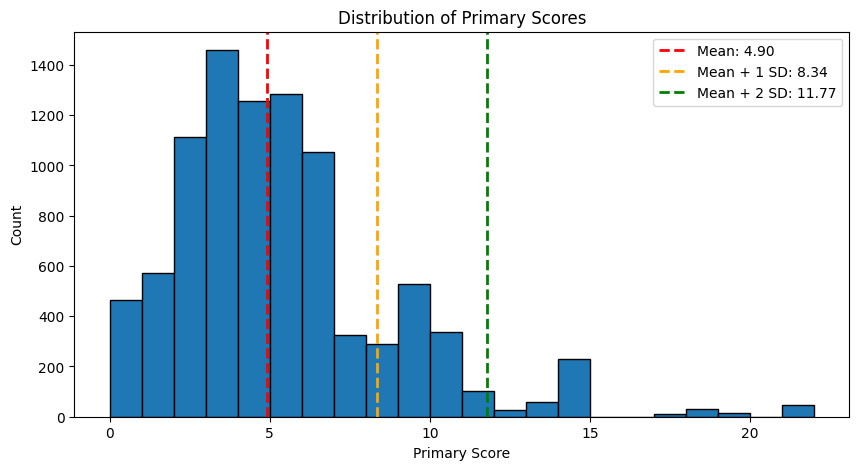

In [ ]:
import matplotlib.pyplot as plt
# First plot: histogram of primary score
plt.figure(figsize=(10, 5))
mean_score = score_df['primary_score'].mean()
std_score = score_df['primary_score'].std()
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.2f}')
plt.axvline(mean_score + std_score, color='orange', linestyle='--', linewidth=2, label=f'Mean + 1 SD: {mean_score + std_score:.2f}')
plt.axvline(mean_score + 2*std_score, color='green', linestyle='--', linewidth=2, label=f'Mean + 2 SD: {mean_score + 2*std_score:.2f}')


plt.hist(score_df['primary_score'], bins=range(0, 23), edgecolor='black')
plt.xlabel('Primary Score')
plt.ylabel('Count')
plt.title('Distribution of Primary Scores')
plt.legend()
plt.show()

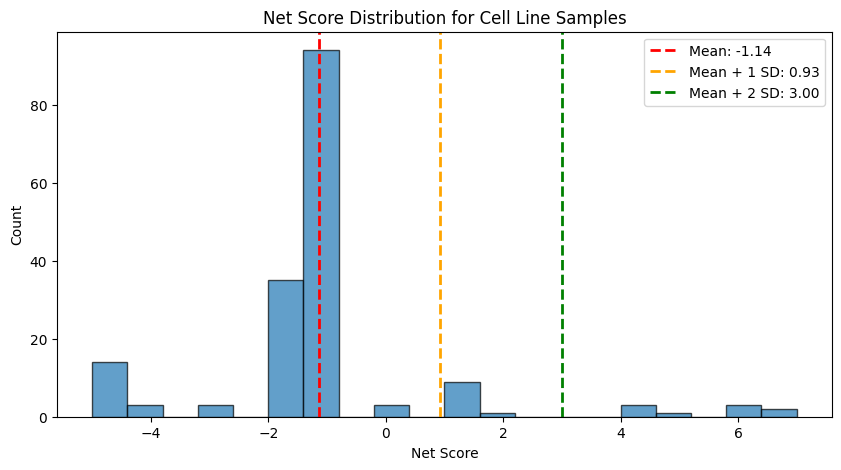

In [ ]:
cell_line_samples = score_df.filter(pl.col('score_cell_line_col') == -1)
net_scores = cell_line_samples['net_score']

plt.figure(figsize=(10, 5))
plt.hist(net_scores, bins=20, edgecolor='black', alpha=0.7)

# Add mean and std lines
mean_score = net_scores.mean()
std_score = net_scores.std()
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.2f}')
plt.axvline(mean_score + std_score, color='orange', linestyle='--', linewidth=2, label=f'Mean + 1 SD: {mean_score + std_score:.2f}')
plt.axvline(mean_score + 2*std_score, color='green', linestyle='--', linewidth=2, label=f'Mean + 2 SD: {mean_score + 2*std_score:.2f}')

plt.xlabel('Net Score')
plt.ylabel('Count')
plt.title('Net Score Distribution for Cell Line Samples')
plt.legend()
plt.show()

lets check if there are samples with conflicting results

In [ ]:
suspicious_samples = score_df.filter(
    ((pl.col('score_cell_line_col') <= -1) | (pl.col('score_cell_line_text') <= -1)) & 
    (pl.col('net_score') >= 0)
)
print(f"Samples with cell line indicators but non-negative net score: {len(suspicious_samples)}")


Samples with cell line indicators but non-negative net score: 119


let's inspect some of these to get an idea of what they are, but for now we'll be mindful of their existence. I don't want to delete them since i may want to use their presence to rule out some experiments

In [ ]:
examine = suspicious_samples['refinebio_accession_code'].sample(n=5) 

for sample in examine:
    sample_summary(sample)
    print()
    print()

score_age: 1
score_cell_line_text: -2
score_primary_human_text: 4
net_score: 3
primary_score: 5
cell_line_score: 2
series_title: Subpopulations of MDA-MB-231 and Primary Breast Cancers
series_summary: Subpopulations of MDA-MB-231 that exhibit different metastatic tropisms when injected into immuno-deficient mice.  Also, a cohort of primary breast cancers surgically resected at the Memorial Sloan-Kettering Cancer Center (MSKCC).
Keywords = Breast cancer
Keywords = lung metastasis
Keywords: parallel sample
refinebio_title: B56-T
refinebio_source_database: GEO
description: RNA was extracted using a Quiagen RNeasy kit from homogenized frozen tumors


score_metastasis: 1
score_cell_line_col: -1
score_cell_line_text: -6
score_primary_human_text: 13
net_score: 7
primary_score: 14
cell_line_score: 7
series_title: Comparative expression of bone metastasis clones and their parent cells Chinese lung adenocarcinoma cell lines CPA-Yang1, CPA-Yang2, CPA-Yang3, SPC-A-1 and human larger cell lung canc

refinebio_source_database: GEO
description: RNA was extracted using a Quiagen RNeasy kit from homogenized frozen tumors


score_age: 1
score_cell_line_text: -2
score_primary_human_text: 4
net_score: 3
primary_score: 5
cell_line_score: 2
series_title: Subpopulations of MDA-MB-231 and Primary Breast Cancers
series_summary: Subpopulations of MDA-MB-231 that exhibit different metastatic tropisms when injected into immuno-deficient mice.  Also, a cohort of primary breast cancers surgically resected at the Memorial Sloan-Kettering Cancer Center (MSKCC).
Keywords = Breast cancer
Keywords = lung metastasis
Keywords: parallel sample
refinebio_title: B52-T
refinebio_source_database: GEO
description: RNA was extracted using a Quiagen RNeasy kit from homogenized frozen tumors




# 5 flag cancer

let's inspect some of these to get an idea of what they are, but for now we'll be mindful of their existence. I don't want to delete them since i may want to use their presence to rule out some experiments

we'll ignore the experminets from which the suspicicous samples came, and then we'll group by experiment, sort by highest primary score and examine a sample from each of the top 10

first, we're going to try and filter to samples which are cancerous by finding column names that inidicate cnacer and then we'll flag smaples where these aren't null

In [ ]:
# Cancer column name patterns
CANCER_COL_PATTERNS = {
    'tumor': make_pattern(r'tumor|tumour'),
    'cancer': make_pattern(r'cancer'),
    'malignancy': make_pattern(r'malignan\w*|neoplasm\w*'),
    'stage': make_pattern(r'stage|grade'),  # Reusing from primary indicators - ignote. too many
    'metastasis': make_pattern(r'metasta\w*'),  # Reusing from primary indicators
    'histology': make_pattern(r'histolog\w*|histopatholog\w*'),  # Reusing from primary indicators #ignore. too many
    'oma_suffix': make_pattern(r'\w*oma'),  # Words ending in 'oma' # ignore. didn't add anything
    'cancer_types': r'.*(?:carcinoma|adenocarcinoma|melanoma|leukemia|leukaemia|lymphoma|sarcoma|glioblastoma|blasts?).*',
}

# Compile each pattern
cancer_col_regex = {
    key: re.compile(pattern, re.IGNORECASE)
    for key, pattern in CANCER_COL_PATTERNS.items()
}
# Find cancer indicator columns
cancer_indicator_cols = {key: [] for key in CANCER_COL_PATTERNS.keys()}
for col in all_columns:
    for indicator_type, regex in cancer_col_regex.items():
        if regex.search(col):
            cancer_indicator_cols[indicator_type].append(col)

print("Cancer indicator columns:")
for indicator_type, cols in cancer_indicator_cols.items():
    print(f"  {indicator_type}: {len(cols)} columns")
    if cols:
        print(f"    Examples: {cols[:5]}")


Cancer indicator columns:
  tumor: 30 columns
    Examples: ['characteristics_ch1_Tumor Site', 'characteristics_ch1_baseline tumor size (cm)', 'characteristics_ch1_histophatological type of tumor', 'characteristics_ch1_invasive tumour type', 'characteristics_ch1_invasive_tumor_area_size1 [mm]']
  cancer: 4 columns
    Examples: ['characteristics_ch1_DFS EVENT (0=censored; 1=event defined as any type of recurrence (local, regional or distant) or death from breast cancer', 'characteristics_ch1_cancer grade', 'characteristics_ch1_death due to cancer', 'characteristics_ch1_tp53 accumulation in cancer cells (assesed by immunohistochemistry)']
  malignancy: 1 columns
    Examples: ['characteristics_ch1_malignancy']
  stage: 43 columns
    Examples: ['refinebio_disease_stage', 'characteristics_ch1_AJCC Stage', 'characteristics_ch1_Elston (NGS) histologic grade', 'characteristics_ch1_Genetic grade signature status prediction (by SWS classifier)', 'characteristics_ch1_Grade']
  metastasis: 3 co

In [ ]:
print("  - Scoring by non Null cancer indicator columns...")
# Count how many cancer indicator column types have non-null values
cancer_score = pl.lit(0)
for indicator_type, cols_list in tqdm(cancer_indicator_cols.items(), desc="  Cancer indicators"):
    condition = pl.lit(False)
    for col in cols_list: 
        condition = condition | novel_samples[col].is_not_null()
    
    cancer_score = cancer_score + pl.when(condition).then(1).otherwise(0)

score_df = score_df.with_columns([
    cancer_score.alias('score_cancer_cols')
])

  - Scoring by non Null cancer indicator columns...


  Cancer indicators:   0%|          | 0/8 [00:00<?, ?it/s]

  Cancer indicators: 100%|██████████| 8/8 [00:00<00:00, 215.41it/s]

In [ ]:
score_df['score_cancer_cols'].value_counts()

score_cancer_cols,count
i32,u32
2,1671
0,5345
4,209
3,638
1,1338


so we can see that demanding caner score > 1, already brings us down to ~2000 samples

In [ ]:
CANCER_TEXT_TERMS = [
    r'\bcarcinoma\b', r'\badenocarcinoma\b', r'\bmelanoma\b',
    r'\bleukemia\b', r'\bleukaemia\b', r'\blymphoma\b', 
    r'\bsarcoma\b', r'\bglioblastoma\b', r'\bblasts?\b',
    r'\btumou?r\b',  # matches tumor or tumour
    r'\bmetasta\w*\b',  # metastasis, metastatic, etc.
    r'\bneoplasm\w*\b',  # neoplasm, neoplastic, etc.
    r'\bb symptoms\b',
]

cancer_text_regex = re.compile('|'.join(CANCER_TEXT_TERMS), re.IGNORECASE)

# Count primary human pattern matches across all text columns
text_cancer_score = pl.lit(0)
for col in text_cols_string_only:
    text_cancer_score = text_cancer_score + (
        novel_samples[col].str.count_matches(cancer_text_regex.pattern, literal=False).fill_null(0)
    )

score_df = score_df.with_columns([
    text_cancer_score.alias('score_cancer_text')
])

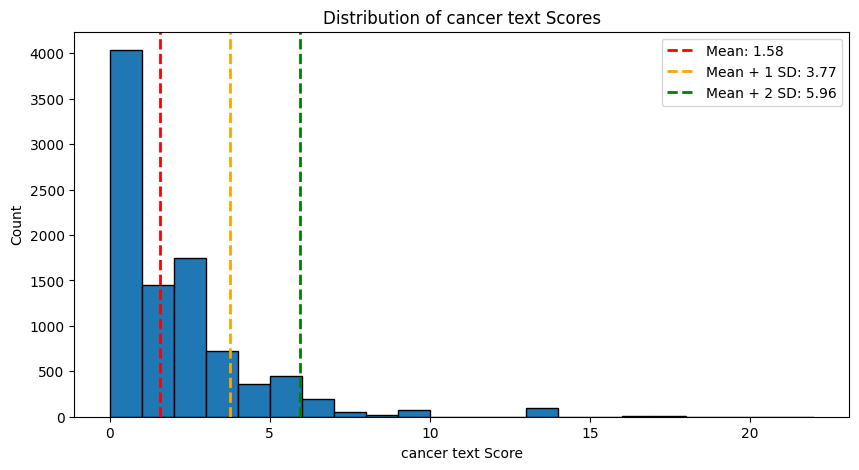

In [ ]:
# First plot: histogram of primary score
plt.figure(figsize=(10, 5))
mean_score = score_df['score_cancer_text'].mean()
std_score = score_df['score_cancer_text'].std()
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.2f}')
plt.axvline(mean_score + std_score, color='orange', linestyle='--', linewidth=2, label=f'Mean + 1 SD: {mean_score + std_score:.2f}')
plt.axvline(mean_score + 2*std_score, color='green', linestyle='--', linewidth=2, label=f'Mean + 2 SD: {mean_score + 2*std_score:.2f}')


plt.hist(score_df['score_cancer_text'], bins=range(0, 23), edgecolor='black')
plt.xlabel('cancer text Score')
plt.ylabel('Count')
plt.title('Distribution of cancer text Scores')
plt.legend()
plt.show()

In [ ]:
len(score_df.filter(pl.col('score_cancer_text') >= 4))

1248

In [ ]:
bad_exps = suspicious_samples['experiment_accession'].unique()
clean_score_df = score_df.filter(~pl.col('experiment_accession').is_in(bad_exps.to_list()))


In [ ]:
print("=== GROUPING BY EXPERIMENT ===\n")

# Calculate averages excluding zeros
experiment_scores = clean_score_df .group_by('experiment_accession').agg([
    pl.count('refinebio_accession_code').alias('n_samples'),
    # Average primary_score excluding zeros
    pl.col('primary_score').filter(pl.col('primary_score') > 0).mean().alias('avg_primary_score'),
    # Average cell_line_score excluding zeros
    pl.col('cell_line_score').filter(pl.col('cell_line_score') > 0).mean().alias('avg_cell_line_score'),
    # Net score - keep normal average
    pl.mean('net_score').alias('avg_net_score'),
    pl.mean('score_cancer_text').alias('avg_cancer_text'),
    pl.mean('score_cancer_cols').alias('avg_cancer_cols'),
]).sort('avg_net_score', descending=True)

# Join series metadata
experiment_scores = experiment_scores.join(experiment_data_pl, on='experiment_accession', how='left')


=== GROUPING BY EXPERIMENT ===



# 6 response columns

# 6 response columns

In [ ]:
# Filter experiments: cancer_text > 3 OR cancer_cols > 0
candidate_experiments = experiment_scores.filter(
    (pl.col('avg_cancer_text') > 3) | (pl.col('avg_cancer_cols') > 0)
).sort('avg_primary_score', descending=True)

print(f"Candidate experiments: {len(candidate_experiments)}")
print(f"Total samples available: {candidate_experiments['n_samples'].sum():,}")

Candidate experiments: 71
Total samples available: 4,322
